In [1]:
import mne
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import yasa
import pywt
from scipy.stats import skew
from scipy.stats import kurtosis
from loading import edfloader, feature_vector

/Users/martinnguyen/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Initialization
Directory selection and reading the raw .edf files

In [2]:
len(['FP1-F7',
 'F7-T7',
 'T7-P7',
 'P7-O1',
 'FP1-F3',
 'F3-C3',
 'C3-P3',
 'P3-O1',
 'FZ-CZ',
 'CZ-PZ',
 'FP2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'FP2-F8',
 'F8-T8',
 'T8-P8',
 'P8-O2'])

18

/Users/martinnguyen/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Channels

['FP1-F7',
 'F7-T7',
 'T7-P7',
 'P7-O1',
 'FP1-F3',
 'F3-C3',
 'C3-P3',
 'P3-O1',
 'FZ-CZ',
 'CZ-PZ',
 'FP2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'FP2-F8',
 'F8-T8',
 'T8-P8',
 'P8-O2']

In [3]:
rootdir='/Users/martinnguyen/Desktop/epilepticseizures/data'
case = '/chb01'
file = '/chb01_03.edf'


directory = rootdir+case+file

raw = edfloader(directory)
raw

Extracting EDF parameters from /Users/martinnguyen/Desktop/epilepticseizures/data/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/Users/martinnguyen/Desktop/epilepticseizures/loading.py:18: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(directory, eog=None, misc=None,


<RawEDF | chb01_03.edf, 18 x 921600 (3600.0 s), ~126.6 MB, data loaded>

In [4]:
replace_dict = {}
drop_list = []
# for the channel names in the data...
for channel_name in raw.info['ch_names']:
    # get the name to change too
    name_change = re.findall('\w+',channel_name)[0].title()
    # check if it is already in the change list
    if name_change in list(replace_dict.values()):
        drop_list.append(channel_name)
    else:
        # if its not already there get the origional name and what we want to 
        # change it to
        replace_dict[channel_name] = name_change

# drop the ones that would be repeats
raw.drop_channels(drop_list)
# rename the channels
raw.rename_channels(replace_dict)
# set the standard montage
montage =  mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, match_case=False)

<RawEDF | chb01_03.edf, 16 x 921600 (3600.0 s), ~112.5 MB, data loaded>

In [8]:
replace_dict

{'FP1-F7': 'Fp1',
 'F7-T7': 'F7',
 'T7-P7': 'T7',
 'P7-O1': 'P7',
 'F3-C3': 'F3',
 'C3-P3': 'C3',
 'P3-O1': 'P3',
 'FP2-F4': 'Fp2',
 'F4-C4': 'F4',
 'C4-P4': 'C4',
 'P4-O2': 'P4',
 'F8-T8': 'F8',
 'T8-P8': 'T8',
 'P8-O2': 'P8',
 'FZ-CZ': 'Fz',
 'CZ-PZ': 'Cz'}

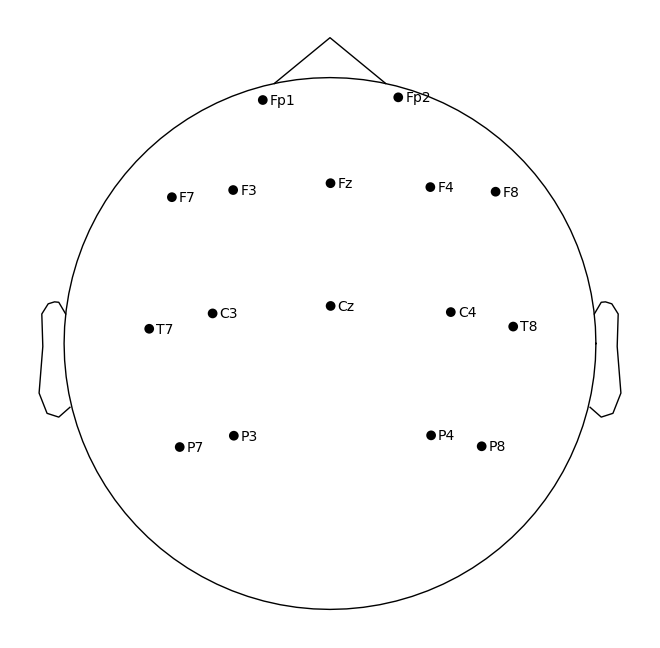

In [21]:
_ = raw.plot_sensors(kind='topomap', show_names=True, to_sphere=True)


In [69]:
rootdir='/Users/martinnguyen/Desktop/epilepticseizures/data'
case = '/chb08'
file = '/chb08_02.edf'

directory = rootdir+case+file

raw = edfloader(directory)
raw

channels = ['FP1-F7',
 'F7-T7',
 'T7-P7',
 'P7-O1',
 'FP1-F3',
 'F3-C3',
 'C3-P3',
 'P3-O1',
 'FZ-CZ',
 'CZ-PZ',
 'FP2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'FP2-F8',
 'F8-T8',
 'T8-P8',
 'P8-O2']

if(all(channel in raw.info['ch_names'] for channel in channels)):
    print('yes')
    
else:
    print('no')


Extracting EDF parameters from /Users/martinnguyen/Desktop/epilepticseizures/data/chb08/chb08_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/var/folders/0d/_7rr9tyj2jqgk85wqmn7fv6h0000gn/T/ipykernel_15293/2395491127.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(directory, eog=None, misc=None,


yes


In [27]:
# annotate seizure data
seizure_start = 2996 # in seconds
seizure_end = 3036
seizure_duration = seizure_end - seizure_start
annotation = mne.Annotations(onset=[0, seizure_start, seizure_end], 
                             duration=[seizure_start, seizure_duration, ((60*59)-seizure_end)], 
                             description=['Background', 'Seizure', 'Background'])
raw.set_annotations(annotation)
raw.annotations

<Annotations | 3 segments: Background (2), Seizure (1)>

In [28]:
# plot parameters
plot_kwargs = {
    'scalings': dict(eeg=25e-5),   # zooms the plot out
    'show_scrollbars': False,
    'show': True
}

Using matplotlib as 2D backend.


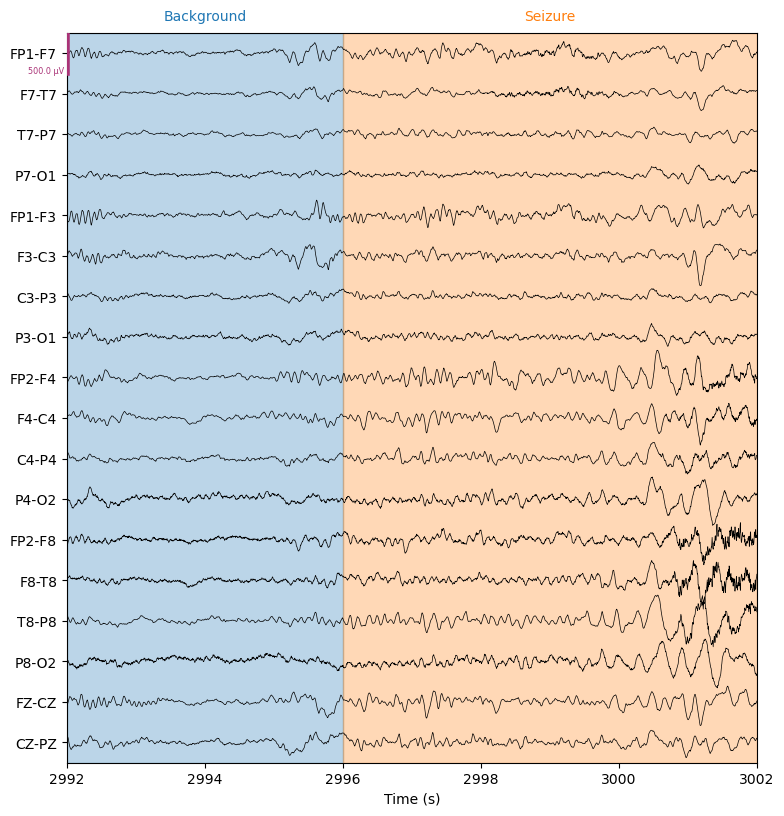

In [9]:
_ = raw.plot(start=seizure_start-4, duration=10, **plot_kwargs) # 4s before seizure start


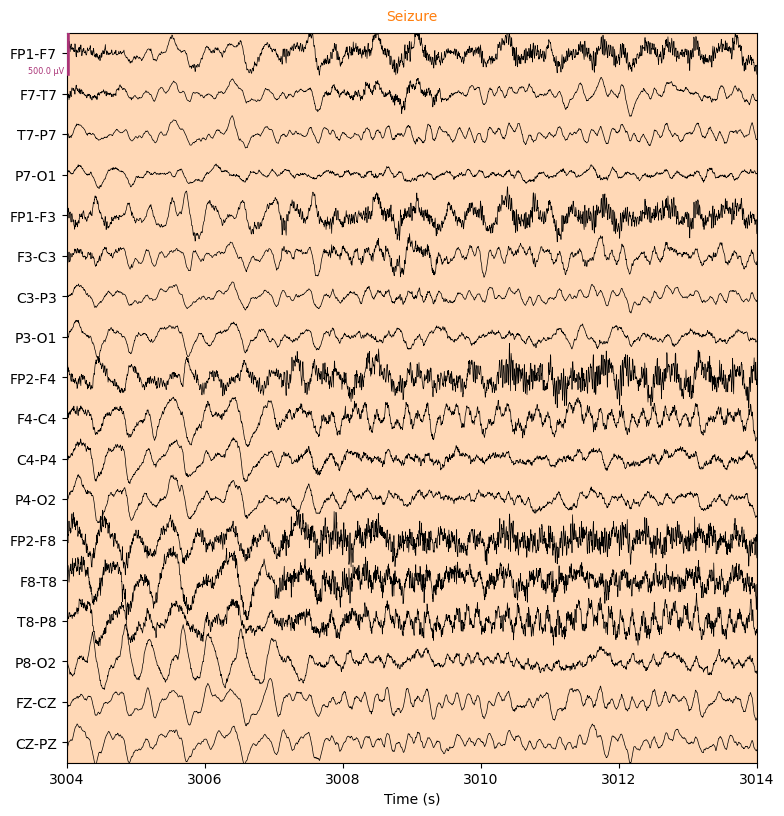

In [10]:
_ = raw.plot(start=seizure_start+8, duration=10, **plot_kwargs) # continued from above...


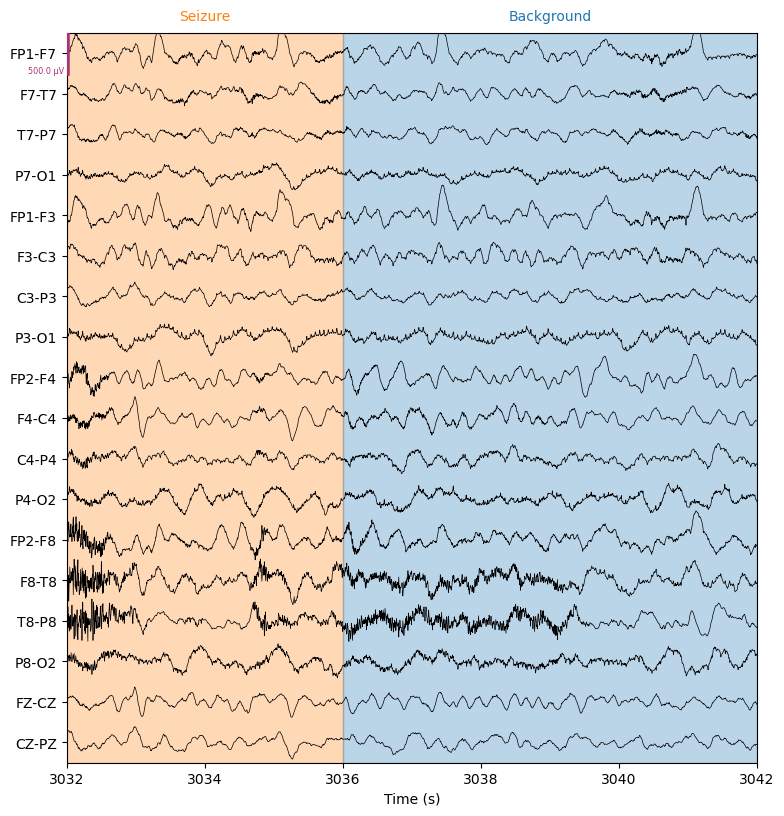

In [11]:
_ = raw.plot(start=seizure_end-4, duration=10, **plot_kwargs) # 4s before seizure ends


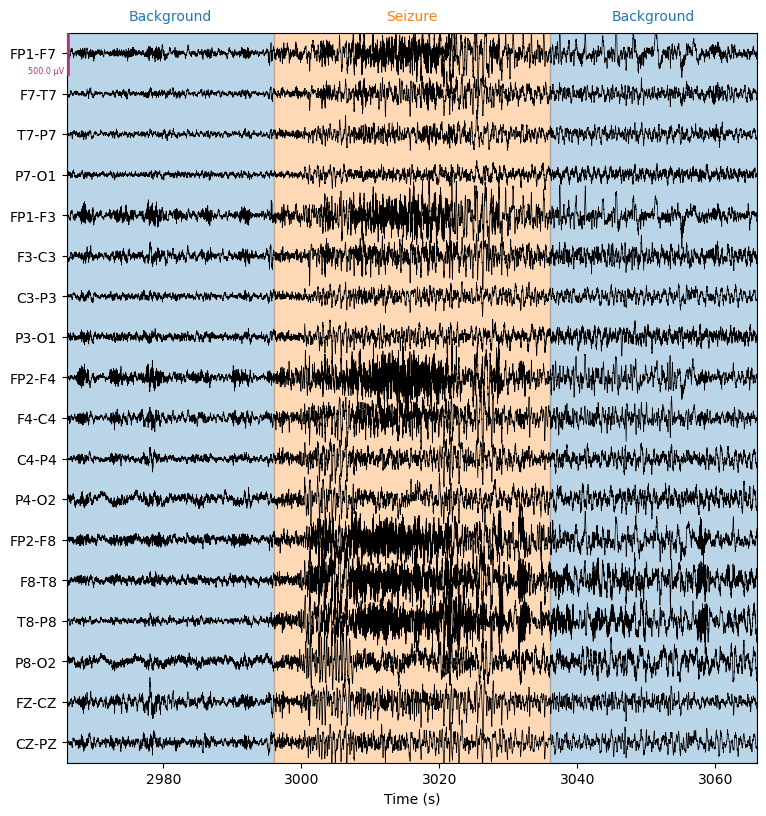

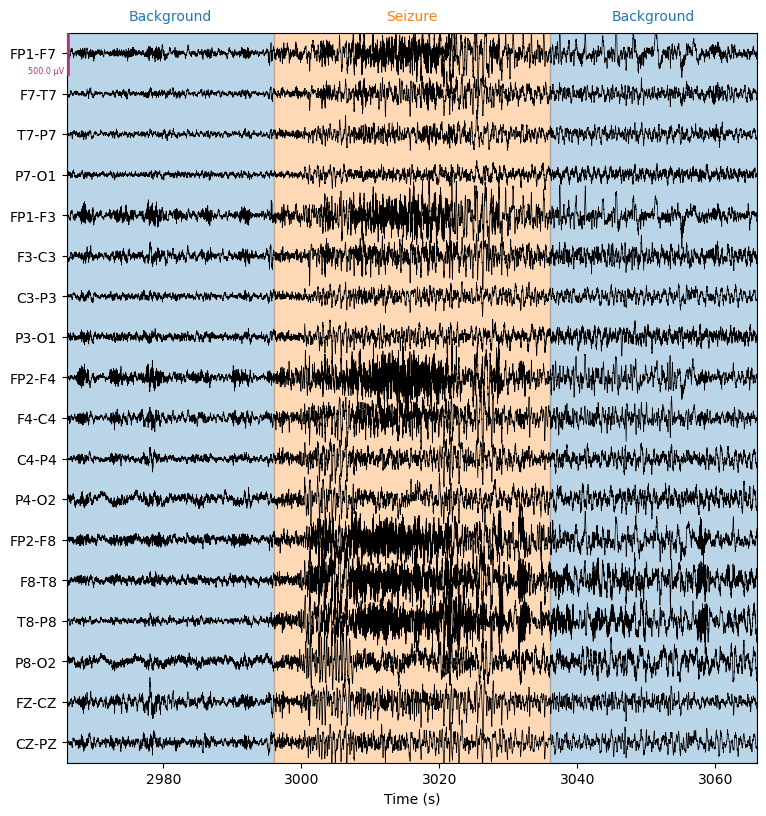

In [38]:
raw.plot(start=seizure_start-30, duration=seizure_duration+60, **plot_kwargs) # whole duration



(18, 25600)


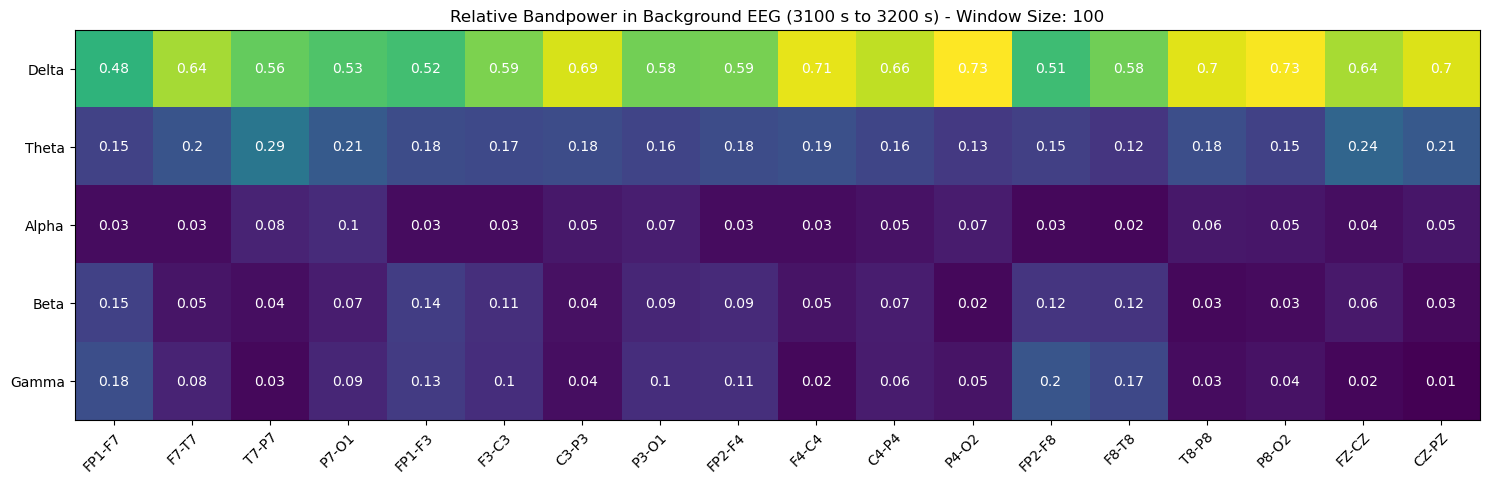

In [12]:
selected_bands = [(1, 4, 'Delta'),
         (4, 8, 'Theta'),
         (8, 12, 'Alpha'),
         (12, 30, 'Beta'),
         (30, 127,'Gamma')]


# determine the dominant brain wave in all channels background period
sampling_freq = raw.info['sfreq']
start_stop_seconds = np.array([3100, 3200])
window_size = start_stop_seconds[1]-start_stop_seconds[0]
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, start_sample:stop_sample]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)
df.iloc[:,0:6]

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Background EEG ({start_stop_seconds[0]} s to {start_stop_seconds[1]} s) - Window Size: {window_size}')
fig.tight_layout()
plt.show()

(18, 10240)


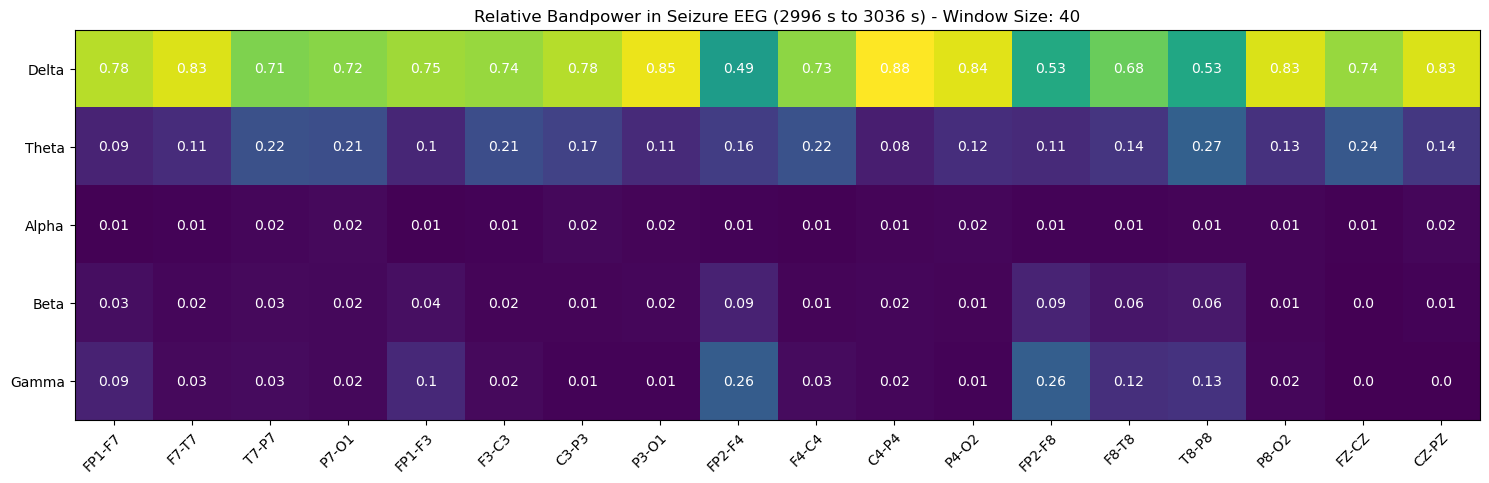

In [13]:
# determine the dominant brain wave in all channels background period
sampling_freq = raw.info['sfreq']
start_stop_seconds = np.array([2996 , 3036])
window_size = start_stop_seconds[1]-start_stop_seconds[0]
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, start_sample:stop_sample]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)
df.iloc[:,0:6]

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(15,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG ({start_stop_seconds[0]} s to {start_stop_seconds[1]} s) - Window Size: {window_size}')
fig.tight_layout()
plt.show()

In [ ]:
rootdir='/Users/martinnguyen/Desktop/epilepticseizures/data'
case = '/chb18'
file = '/chb18_29.edf'

directory = rootdir+case+file

raw = edfloader(directory)
len(raw.info['ch_names'])

channels = ['FP1-F7','F7-T7','T7-P7','P7-O1','FP1-F3','F3-C3','C3-P3','P3-O1','FZ-CZ','CZ-PZ','FP2-F4','F4-C4','C4-P4','P4-O2','FP2-F8','F8-T8','T8-P8','P8-O2']

for channel in raw.info['ch_names']:
    if channel not in channels:
        print(channel)

In [ ]:
df = pd.read_excel('output.xlsx', index_col=0)
patient = ['chb01', 'chb24']
feature_list = []

for j in patient:
    idx_patient = df.index[(df['case'] == j)].tolist()
    
    for i in idx_patient:
        rootdir='/Users/martinnguyen/Desktop/epilepticseizures/data'
        case = '/'+df['case'][i]
        file = '/'+df['seizure_file'][i]+'.edf'

        directory = rootdir+case+file

        raw = edfloader(directory)

        times = [df['seizure_start'][i],df['seizure_end'][i]]

        feature_list.append(feature_vector(raw, times))



patient = ['chb02','chb03','chb04','chb05','chb06','chb07','chb08','chb09',
         'chb10', 'chb11','chb12','chb13','chb14','chb15','chb16','chb17','chb18',
         'chb19','chb20', 'chb21', 'chb22','chb23']

for j in patient:
    idx_patient = df.index[(df['case'] == j)].tolist()
    
    for i in idx_patient:
        rootdir='/Users/martinnguyen/Desktop/epilepticseizures/data'
        case = '/'+df['case'][i]
        file = '/'+df['seizure_file'][i]+'.edf'

        directory = rootdir+case+file

        raw = edfloader(directory)

        times = [df['seizure_start'][i],df['seizure_end'][i]]

        feature_list.append(feature_vector(raw, times))
